In [46]:
using Plots
using Interact
using Distributions
using RandomMatrices

┌ Info: Recompiling stale cache file C:\Users\matte\.julia\compiled\v1.2\Interact\XmYW4.ji for Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1240


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-12589776457119003439\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-5311059250349592638\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-12589776457119003439\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
function tw_pdf(xs, step)
    c = cdf(TracyWidom, vcat(vcat(xs[1]-step,xs),xs[end]+step))
    d = (diff(c)[1:end-1]+diff(c)[2:end]) / (2*step)
    return d
end

step = 0.1
min_, max_ = -6, 6
xs = min_:step:max_
TW_pdf = tw_pdf(xs, step);

In [41]:
function m_G(wait)
    N = size(wait)[1]
    memg = zeros(N, N) .- 1 #trunc.(Int, zeros(N,N)) .- 1
    memg[1, 1] = 0
#     for i in 1:N
#         memg[i, 1] = 0
#         memg[1, i] = 0
#     end
    function tmp_G(i, j, wait)
        if(memg[i, j] == -1)
            if(i==1)
                res1 = tmp_G(i, j-1, wait)
                memg[i, j-1] = res1
                res = res1 + wait[i, j] #+1
            elseif(j==1)
                res1 = tmp_G(i-1, j, wait)
                memg[i-1, j] = res1
                res = res1 + wait[i, j] #+1
            else
                res1 = tmp_G(i, j-1, wait)
                res2 = tmp_G(i-1, j, wait)
                memg[i, j-1] = res1
                memg[i-1, j] = res2
                res = max(res1, res2) + wait[i, j] #+1
            end
            memg[i, j] = res
        end
        return memg[i, j]
    end
    tmp_G(N, N, wait)
    return memg
end

m_G (generic function with 1 method)

In [39]:
function get_grid(law, N)
    w = rand(law, N, N)
    grid = m_G(w)
    return grid
end

get_grid (generic function with 1 method)

In [148]:
## http://www.math.cmu.edu/~eemrah/CGM_TW.pdf
## https://www.math.utah.edu/~firas/FPD16/Talks/Emrah.pdf
## https://arxiv.org/pdf/math/9903134.pdf
## https://arxiv.org/pdf/1612.08521.pdf

function renorm_params(law)
    r = 1
    if typeof(law) == Geometric{Float64}
        q = params(law)[1]
        q = (1-q)
        γ = (q*(1+r) + 2*√(q*r)) / (1-q)
        σ = (1/(1-q)) * (q/r)^(1/6) * (√q + √r)^(2/3) * (1 + √(q*r))^(2/3)
    elseif typeof(law) == Exponential{Float64}
        λ = 1 / params(law)[1]
        γ = (1+√r)^2 / λ
        σ = r^(-1/6) * (1+r)^(4/3)
    end
    return γ, σ
end

renorm_params (generic function with 1 method)

In [146]:
N = 400
res = Float64[]
for i in 1:100
    append!(res, get_grid(Geometric(0.2), N)[N, N])
end

In [140]:
mean(res)/N, std(res)/(N^(1/3))

(15.4628, 8.724268724692603)

In [142]:
mean(res)/N, std(res)/(N^(1/3))

(16.0272, 10.071457838505559)

In [144]:
mean(res)/N, std(res)/(N^(1/3))

(16.357, 10.916986771400781)

In [147]:
mean(res)/N, std(res)/(N^(1/3))

(16.626199999999997, 10.51944911127134)

In [135]:
renorm_params(Geometric(0.2))

(16.94427190999916, 1.564798870444482)

72.0369230521979

In [68]:
@manipulate for max_N = 100:50:1000, law_name = ["Geometric(q)", "Exponential(λ)"], q = 0.05:0.05:0.95, λ = 1:1:10
    if(law_name == "Geometric")
        law = Geometric(q)
    else
        law = Exponential(λ)
    end
    γ, σ = renorm_params(law)
    grid = get_grid(law, max_N)
    diag = [grid[i,i] / i for i in 1:max_N]
    plot(1:max_N, diag, lw = 3, color = "red", legend=:bottomleft, xlabel = "N", label = "empirical T(N,N)")
    hline!([γ], lw = 3, color = "black", label = "theoretical limit")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["max_N"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 19,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
10, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\matte\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\matte\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\matte\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\matte\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\matte\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000002feef0f0, Task (runnable) @0x000000002feef0f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"100\",\"150\",\"200\",\"250\",\"300\",\"350\",\"400\",\"450\",\"500\",\"550\",\"600\",\"650\",\"700\",\"750\",\"800\",\"850\",\"900\",\"950\",\"1000\"],\"changes\":WebIO.getval({\"name

In [196]:
RANGE_N = 10:10:100
max_N = maximum(RANGE_N)
RANGE_q = 0.1*(1:9)
RANGE_λ = 1:10
NB_EXAMPLES = 300

d = Dict(vcat(("Geometric",Dict([(q, Dict([(N, Float64[]) for N in RANGE_N])) for q in RANGE_q])), ("Exponential",Dict([(λ, Dict([(N, Float64[]) for N in RANGE_N])) for λ in RANGE_λ]))))

for q in RANGE_q
    println("Geometric, ", q)
    law = Geometric(q)
    res = Float64[]
    for i in 1:NB_EXAMPLES
        grid = get_grid(law, max_N)
        for N in RANGE_N
            append!(d["Geometric"][q][N], grid[N, N])
        end
    end
end

for λ in RANGE_λ
    println("Exponential, ", λ)
    law = Exponential(λ)
    res = Float64[]
    for i in 1:NB_EXAMPLES
        grid = get_grid(law, max_N)
        for N in RANGE_N
            append!(d["Exponential"][λ][N], grid[N, N])
        end
    end
end

Geometric, 0.1
Geometric, 0.2
Geometric, 0.3
Geometric, 0.4
Geometric, 0.5
Geometric, 0.6
Geometric, 0.7
Geometric, 0.8
Geometric, 0.9
Exponential, 1
Exponential, 2
Exponential, 3
Exponential, 4
Exponential, 5
Exponential, 6
Exponential, 7
Exponential, 8
Exponential, 9
Exponential, 10


In [197]:
@manipulate for N = RANGE_N, law_name = ["Geometric", "Exponential"], q = RANGE_q, λ = RANGE_λ
    if(law_name == "Geometric")
        res = d[law_name][q][N]
        γ, σ = renorm_params(Geometric(q))
    else
        res = d[law_name][λ][N]
        γ, σ = renorm_params(Exponential(λ))
    end
    norm_res = (res .- γ*N) ./ (σ * N^(1/3))
    histogram(norm_res, normalize=true, bins=-5:0.2:2.5)
    plot!(xs, TW_pdf, lw = 3, color = "red", label = "Tracy-Widom PDF")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["N"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 10,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
5, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\matte\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\matte\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\matte\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\matte\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\matte\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000003051ae10, Task (runnable) @0x000000003051ae10), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"10\",\"20\",\"30\",\"40\",\"50\",\"60\",\"70\",\"80\",\"90\",\"100\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"16827103425311065201\",\"id\":\"ob_517\",\"type\":\"observab

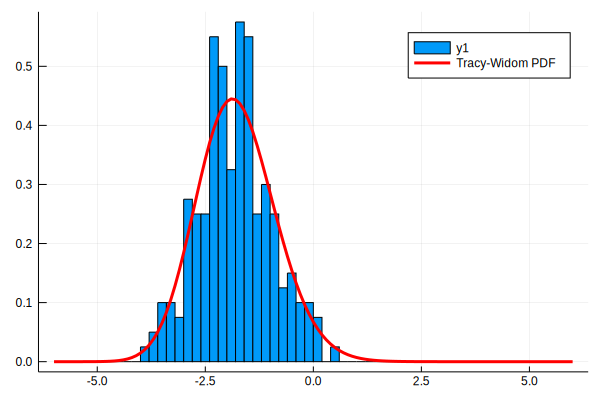

In [149]:
law = Geometric(0.2)
res = Float64[]
N = 100
γ, σ = renorm_params(law)
for i in 1:200
    tnn = get_grid(law, N)[N, N]
    append!(res, tnn)
end 
norm_res = (res .- γ*N) ./ (σ * N^(1/3))
histogram(norm_res, normalize=true, bins=-5:0.2:5)
plot!(xs, TW_pdf, lw = 3, color = "red", label = "Tracy-Widom PDF")

In [8]:
## Add Interact plot -> NB_EXAMPLES slider
## Find the right normalization
## Add option to specify randomness